# Filipino Family Income and Expenditure: Regional Average

In this section, we will perform data grouping based on regions. Grouping the data per region allows us to explore regional disparities, identify unique economic conditions, and understand how family income and expenditures vary across different parts of the country. We seek to answer the following questions:

1. What are the regions with the highest and lowest average family income?
2. How do family expenditures differ across regions?
3. What are the major expense categories for families in different regions?
4. Is there a correlation between family income and certain types of expenditures?
5. Are there any significant outliers in the data that indicate unique economic conditions in certain regions?

# 1. Import Python packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
from data_utils import _remove_income_outlier, _expenditures_data, _income_data, _householdhead_data, _appliances_data, _property_information, _family_composition

# 2. Loading and Categorizing the Dataset

In [3]:
data = pd.read_csv('Family Income and Expenditure.csv')
data = _remove_income_outlier(data)

Categorizing the data into: expenditures, income, household head data, number of appliances, property data, and family composition

In [4]:
from data_utils import _expenditures_data, _income_data, _householdhead_data, _appliances_data, _property_information, _family_composition

expenditures_data = _expenditures_data(data)
income_data = _income_data(data)
householdhead_data = _householdhead_data(data)
appliances_data = _appliances_data(data)
property_data = _property_information(data)
family_composition_data = _family_composition(data)

# Checking if all of the columns have been categorized 
collection = expenditures_data +  income_data + appliances_data +  householdhead_data + family_composition_data +  property_data
missing = [element for element in data.columns if element not in collection]
print(missing)


['Region']


# 3. Exploring the Expenditures

In [5]:
from ipywidgets import interact, fixed
from regional_utils import bar_chart_regional_average, create_dataframe_min_max

c:\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 3.1 Visualizing expenditures per region using bar charts

We will first visualize the total household income and various expenditures per region using bar charts. The dropdown menu can be used to select a certain expenditure. The regions with lowest and highest values are denoted by red and green, respectively. 



In [6]:
keys = ['Total Household Income'] + expenditures_data
interact(bar_chart_regional_average, data=fixed(data), key=keys, average=True)


interactive(children=(Dropdown(description='key', options=('Total Household Income', 'Total Food Expenditure',…

<function regional_utils.bar_chart_regional_average(data, key: str, average: bool = True)>

In [8]:
# Summary of regional average icome and expenditures, showing the region with the highest (0) and lowest (1) average income and expenditures.
max_min_dataframe = create_dataframe_min_max(data, keys)
max_min_dataframe

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses
0,NCR,NCR,CAR,VIII - Eastern Visayas,NCR,ARMM,NCR,CAR,NCR,II - Cagayan Valley,III - Central Luzon,NCR,NCR,IVA - CALABARZON,NCR,NCR,NCR,NCR,IVA - CALABARZON,ARMM
1,ARMM,X - Northern Mindanao,II - Cagayan Valley,IX - Zasmboanga Peninsula,ARMM,X - Northern Mindanao,X - Northern Mindanao,X - Northern Mindanao,ARMM,ARMM,CAR,ARMM,ARMM,ARMM,ARMM,ARMM,ARMM,ARMM,ARMM,NCR


NCR has the highest average household income and food expenditures. The region also has the highest expenditures in meat, fruits, restaurant and hotels, clothing, housing and water, transportation, communication, education, and miscellaneous goods and services. Meanwhile, it had the lowest expenditures for crop farming and gardening.

* As the country's economic and political center, there are more lucrative job opportunities not available in other regions. The availability of opportunities brings more people to the region, resulting in higher demand for housing, consequently raising the costs.
* Similar to housing, other basic necessities such as food are more expensive in the region due to the increased demand. This may also be explained by more expensive food preferences of the residents, i.e. having higher meat and fruits expenditures, which tend to be more expensive than food staples such as bread, cereals, and rice.
* Having the highest expenditures on restaurants and hotels and miscellaneous goods and services may be explained by the availability of such establishments in the region (being highly urbanized) and the expectantly higher disposable income of the residents from having higher income. Furthermore, the urban lifestyle (which gets really busy) may also result in more frequent dining out.
* Communication expenditures may be explained by the increased demand for connectivity, i.e. work, school, socialization, and the availability of high-end services, such as faster and more expensive internet plans.
* Clothing expenditures may be explained by the urban lifestyle, e.g. keeping up with the trends from social media, occupations that require more "professional" attire.
* Transportation expenditures in NCR could be explained by long commutes to work/school using various transportation modes such as buses, trains, jeepneys, and taxis. Although NCR is considered highly urbanized, work and school can be in a city different from one's residence. For instance, Malabon is a city in NCR also considered as highly urbanized, with a lot of job opportunities, but some residents still have a preference for jobs/universities in QC, Manila, Makati, etc., because the jobs are usually blue collar, contractual, or "arawan", while schools are limited to community colleges.
* The region has the lowest expenditures in crop farming and gardening, which is expected from being highly urbanized with limited space for agriculture.

CALABARZON has the highest medical care and special occassions expenditure

## 3.2 Visualizing the relation between income and expenditures using scatter plot

In [9]:
from regional_utils import regional_average_dependence
interact(regional_average_dependence, data=fixed(data), key=expenditures_data)

interactive(children=(Dropdown(description='key', options=('Total Food Expenditure', 'Bread and Cereals Expend…

<function regional_utils.regional_average_dependence(data, key)>

## 3.3 Visualizing the differences in income and expenditure through a choropleth map

In [10]:
import geopandas as gpd
from regional_utils import get_string_inside_parenthesis, make_map_text, load_regions_geodataframe, regional_averages_name_clean, choropleth

In [11]:
data = pd.read_csv('Family Income and Expenditure.csv')
regions_gdf_clean = load_regions_geodataframe()
regional_averages = regional_averages_name_clean(data, keys)

In [12]:
# Adding regional averages to the regions_clean dataframe
merged_df = pd.merge(regions_gdf_clean, regional_averages, left_on='REGION', right_on='Region', how='left')

In [13]:
interact(choropleth, merged_df=fixed(merged_df), key=keys)

interactive(children=(Dropdown(description='key', options=('Total Household Income', 'Total Food Expenditure',…

<function regional_utils.choropleth(merged_df, key)>

# 4. Exploring the Income

## 4.2 Main Sources of Income Per Region

In [14]:
income_data

['Total Household Income',
 'Main Source of Income',
 'Total Income from Entrepreneurial Acitivites']

In [46]:
def stacked_bar(data, key):
    regional_average_column = data.groupby('Region')[key].value_counts().unstack().reset_index()
    ax = regional_average_column.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(key)
    plt.ylabel('Number of Individuals')
    plt.xlabel('Region')
    plt.legend()
    ax.set_xticklabels([entry.split()[0] for entry in regional_average_column["Region"]],  rotation = 0, ha='right')
    plt.tick_params(size=16)
    plt.xlabel("Region", size=16)
    plt.ylabel("Average " + key)
    
    # Change size of ax figure
    fig = plt.gcf()
    fig.set_size_inches(20, 10)


    # Turn off grid
    ax.grid(False)
    
    plt.show()


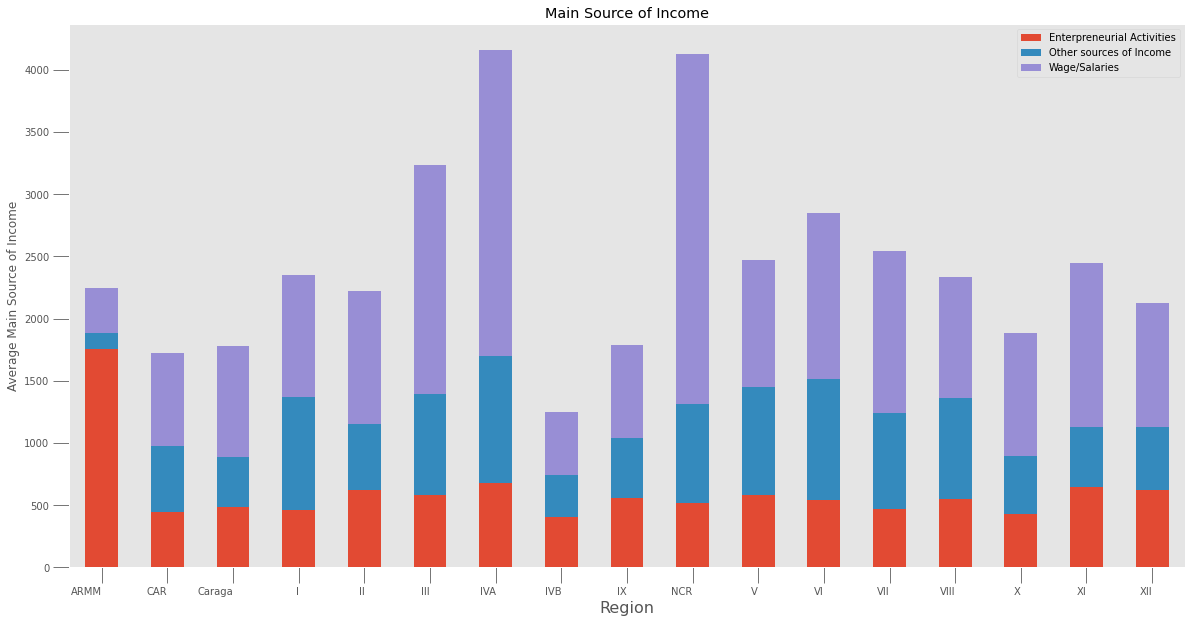

In [47]:
stacked_bar(data, 'Main Source of Income')

In all of the regions, only ARMM relied mostly on entrepreneurial activites as their main source of income. The ARMM region, situated in the southern part of the Philippines, had encountered challenges such as underdeveloped infrastructure, limited access to quality education, and a history of conflict. These factors made it more difficult for traditional industries to thrive and led to a higher reliance on entrepreneurial endeavors.

## 4.1 Income from Entrepreneural Activities

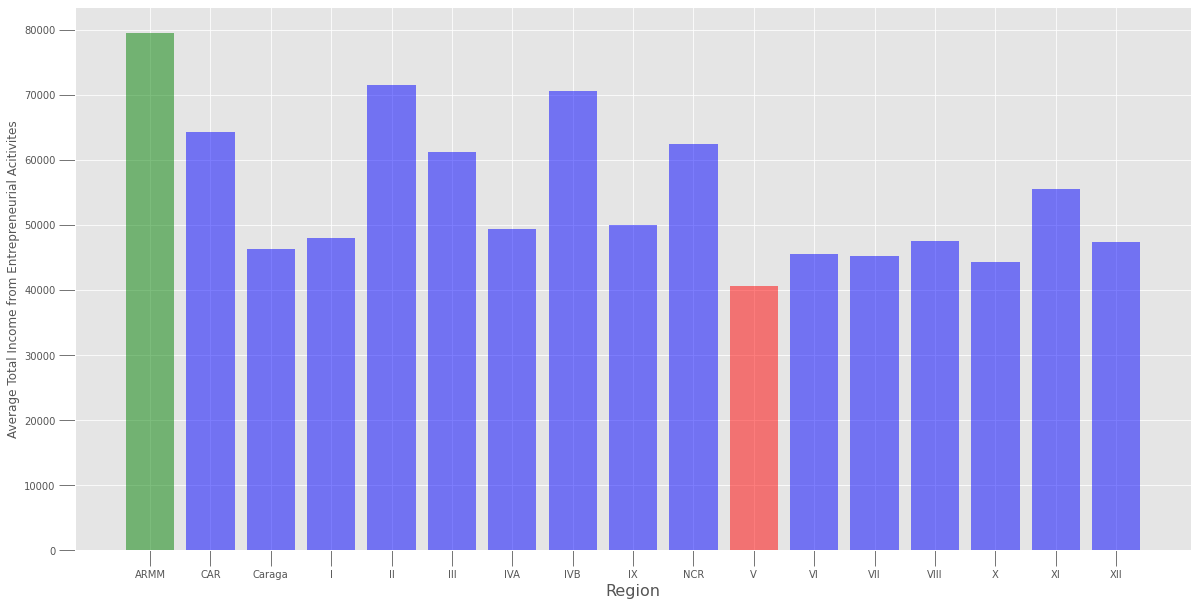

In [48]:
bar_chart_regional_average(data, 'Total Income from Entrepreneurial Acitivites')

# 5. Assets Data

In [58]:
property_data, appliances_data

(['Type of Building/House',
  'Type of Roof',
  'Type of Walls',
  'House Floor Area',
  'Tenure Status',
  'Toilet Facilities',
  'Electricity',
  'Main Source of Water Supply',
  'House Age',
  'Imputed House Rental Value',
  'Number of bedrooms',
  'Agricultural Household indicator'],
 ['Number of Television',
  'Number of CD/VCD/DVD',
  'Number of Component/Stereo set',
  'Number of Refrigerator/Freezer',
  'Number of Washing Machine',
  'Number of Airconditioner',
  'Number of Car, Jeep, Van',
  'Number of Landline/wireless telephones',
  'Number of Cellular phone',
  'Number of Personal Computer',
  'Number of Stove with Oven/Gas Range',
  'Number of Motorized Banca',
  'Number of Motorcycle/Tricycle'])

In [61]:
property_data_continuous = ['House Floor Area', 'House Age', 'Number of bedrooms', 'Imputed House Rental Value'] + appliances_data
property_data_discrete = [item for item in property_data if item not in property_data_continuous] 

## Continuous data

In [62]:
interact(bar_chart_regional_average, data=fixed(data), key=property_data_continuous, average=True)

interactive(children=(Dropdown(description='key', options=('House Floor Area', 'House Age', 'Number of bedroom…

<function regional_utils.bar_chart_regional_average(data, key: str, average: bool = True)>

In [52]:
create_dataframe_min_max(data, property_data_continuous)

,House Floor Area,House Age,Number of bedrooms,Imputed House Rental Value
0,CAR,NCR,CAR,NCR
1,XII - SOCCSKSARGEN,IX - Zasmboanga Peninsula,ARMM,ARMM


CAR has the highest floor area number of bedrooms. 


## Discrete data

In [53]:
interact(stacked_bar, data=fixed(data), key=property_data_discrete, average=True)

interactive(children=(Dropdown(description='key', options=('Type of Building/House', 'Type of Roof', 'Type of …

<function __main__.stacked_bar(data, key)>

# 6. Household Head

In [54]:
householdhead_data

['Household Head Sex',
 'Household Head Age',
 'Household Head Marital Status',
 'Household Head Highest Grade Completed',
 'Household Head Job or Business Indicator',
 'Household Head Occupation',
 'Household Head Class of Worker']

In [55]:
householdhead_data_discrete = householdhead_data[:]
householdhead_data_discrete.remove('Household Head Age')

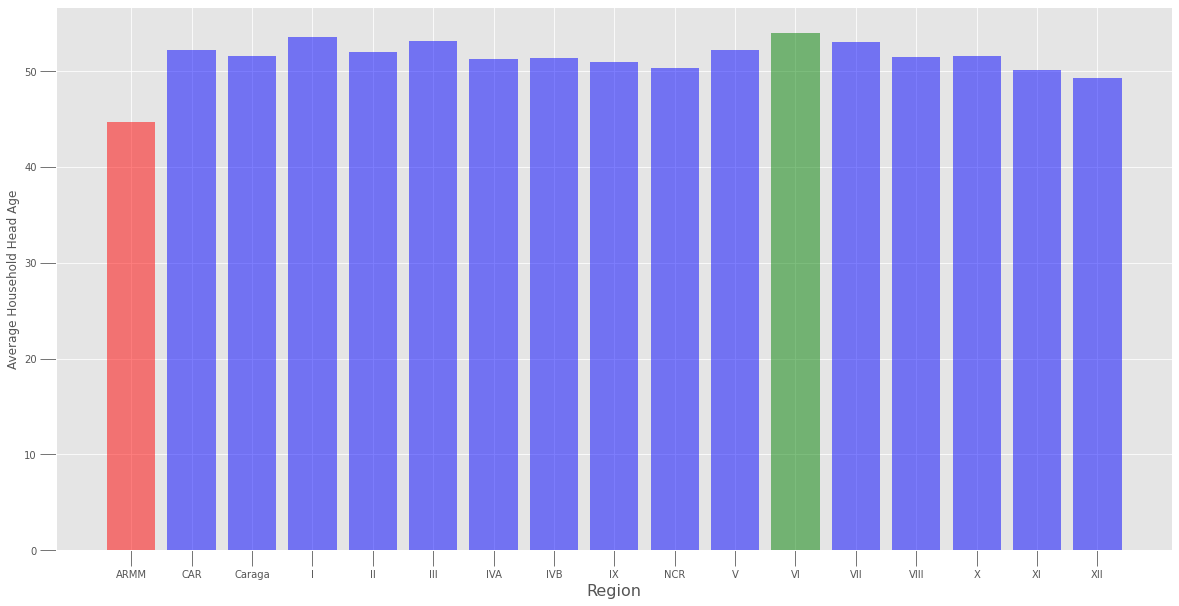

In [56]:
bar_chart_regional_average(data, key='Household Head Age', average=True)

In [57]:
interact(stacked_bar, data=fixed(data), key=householdhead_data_discrete, average=True)

interactive(children=(Dropdown(description='key', options=('Household Head Sex', 'Household Head Marital Statu…

<function __main__.stacked_bar(data, key)>